$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# Greedy algorithms with a 2d manifold

Here we consider the solutions of the PDE $u_h(a(y))$ where $y\in\mathbb{R}^2$, $a(y) = y_1 \chi_{D_1}(x) + y_2 \chi_{D_2}(x)$, and $D_1 = [0,1/2) \times [0,1]$ and $D_2 = [1/2, 1] \times [0,1]$, and $\chi_{D_1}$, $\chi_{D_2}$ are the indicator functions on $D_1$, $D_2$.

We're given our measurement space $W_m = \mathrm{span}\{w_1,\ldots,w_m\}$. We have a series of measurements $\langle w_i, u\rangle_V$, and we write $w := P_{W_m} u$, the projection of $u$ in $W_m$. We try random, even, and even sinusoidal measurements.

__Remarks:__
 - __Note that $\dot{\cdot}{\cdot} = \dot{\cdot}{\cdot}_{V_h}$ here.__
 - We can __assume that the $\omega_i$ are orthonormal__ as it is a fixed basis.
 - We store $\dot{\omega_i}{v}$ for each $v\in \cD$, so can we di all projections and inner-products in $\mathbb{R}^m$? And furthermore without the need of a Gram matrix $\dot{\phi_i}{\phi_j}$ to do the projection or orthonormalisation of $\phi_i$?
 - Finally, remember that _we can not know anything about $u$ other than $w :=P_{W_m} u$_, and we abuse notation slightly and also write $w=\dot{\omega_i}{u}$ for the vector in $\mathbb{R}^m$.

We have a dictionary $\cD$ of solutions $v(y)$, which we get from generating points in $y\in\mathbb{R}^{2}$ and then $v(y) = \frac{u_h(a(y))}{\| u_h(a(y)) \|_{V_h}}$ (i.e. we normalise all elements). 

### Algorithm 1

The first algorithm doesn't depend on $W_m$ at all. Given the dictionary $\cD$ we chose
$$
\phi_1 = {\arg\max}_{v\in\cD} \| v \|
$$
and given $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$, our next choice is
$$
\phi_{n+1} = {\arg\max}_{v\in\cD} \| v - P_{V_n} v \|
$$

### Algorithm 2

The first element $\phi_1$ is chosen as 
$$ \phi_1 = {\arg\max}_{v\in \cD} \adot{w}{v}$$
and given our collection $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$,our next choice is
$$ \phi_{n+1} = {\arg\max}_{v\in \cD} \adot{w}{P_{V_n^\perp} v}$$

### Algorithm 3

$$ \phi_1 = {\arg\max}_{v\in \cD} \adot{w}{v}$$
and given our collection $V_{n}=\mathrm{span}\{\phi_1, \ldots, \phi_n\}$,our next choice is
$$ \phi_{n+1} = {\arg\max}_{v\in \cD} \adot{P_{W_m \cap V_n^\perp} w}{ v}$$


In [6]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

def make_soln(points, fem_div, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = []
    fields = []

    for p in points:
        field = pat.PWConstantSqDyadicL2(a_bar + c * p.reshape((2,2)))
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = field, f = 1)
        fem_solver.solve()
        solns.append(fem_solver.u)
        
    return solns, fields

### Generate the solution $u$ that we want to approximate

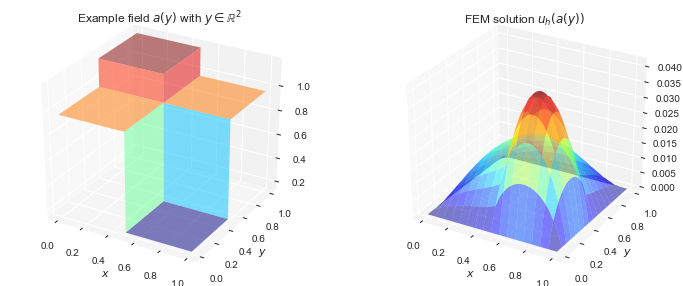

In [7]:
fem_div = 7

a_bar = 0.1
c = 2.0

np.random.seed(2)

y = np.random.random((1,4))

u, a = make_soln(y, fem_div, a_bar=a_bar, c=c)
u = u[0]
a = a[0]

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Example field $a(y)$ with $y\in\mathbb{R}^2$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$')
plt.show()

### Generate the basis $W_m$ of randomly placed local averages

m = 64


[]

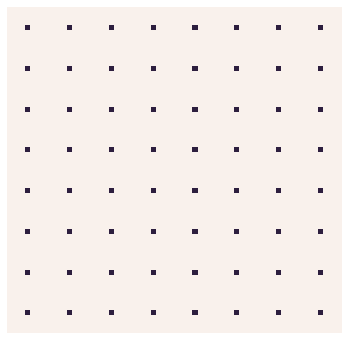

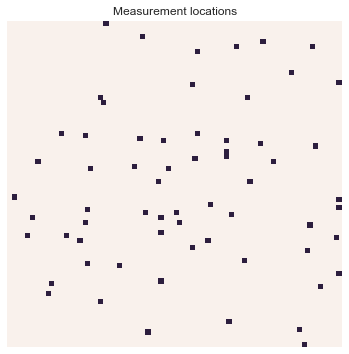

In [3]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 1
local_width = 2**width_div
spacing_div = 4

Wm_reg, Wloc_reg = pat.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm_reg = Wm_reg.orthonormalise()

m = Wm_reg.n
print('m =', m)

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

Wm_rand, Wloc_rand = pat.make_pw_local_avg_random_basis(m=m, div=fem_div, width=local_width, return_map=True)
Wm_rand = Wm_rand.orthonormalise()

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(Wloc_reg.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(Wloc_rand.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Measurement locations')
##plt.savefig('ddgrb_measurements.pdf')
plt.plot()

### Generate the dictionary of snapshots

Note that the $y$ that form the dictionary are on the regular ```dict_n``` $\times$ ```dict_N``` grid in $[0,1]^2$.

In [4]:
dict_N = 10
dict_grid = np.linspace(0.0, 1.0, dict_N, endpoint=False)
y1s, y2s, y3s, y4s = np.meshgrid(dict_grid, dict_grid, dict_grid, dict_grid)

y1s = y1s.flatten()
y2s = y2s.flatten()
y3s = y3s.flatten()
y4s = y4s.flatten()

dict_ys = np.stack([y1s, y2s, y3s, y4s]).T
print('Making dictionary of length', len(dict_ys))
dictionary, dictionary_fields = make_soln(dict_ys, fem_div, a_bar=a_bar, c=c)

Making dictionary of length 10000


In the following, 
 - __```g```__ uses Algorithm 1
 -  __```mbg_rand```__ uses Algorithm 2 with the randomly generated $W_m$ (```Wm_rand``` from above)
 -  __```mbg_reg```__ uses Algorithm 2 with the regular $W_m$ (```Wm_reg``` from above)
 -  __```mbgp_rand```__ uses Algorithm 3 with the random $W_m$
 -  __```mbgp_reg```__ uses Algorithm 3 with the regular $W_m$
 

In [13]:
g = pat.GreedyApprox(dictionary, Vn=pat.PWBasis(), verbose=True, remove=False)
g.construct_to_n(m)

mbg_rand = pat.MeasBasedGreedy(dictionary, Wm_rand.dot(u), Wm_rand, Vn=pat.PWBasis(), verbose=True, remove=False)
mbg_rand.construct_to_n(m)

mbg_reg = pat.MeasBasedGreedy(dictionary, Wm_reg.dot(u), Wm_reg, Vn=pat.PWBasis(), verbose=True, remove=False)
mbg_reg.construct_to_n(m)

mbgp_rand = pat.MeasBasedGreedyPerp(dictionary, Wm_rand.dot(u), Wm_rand, Vn=pat.PWBasis(), verbose=True, remove=False)
mbgp_rand.construct_to_n(m)

mbgp_reg = pat.MeasBasedGreedyPerp(dictionary, Wm_reg.dot(u), Wm_reg, Vn=pat.PWBasis(), verbose=True, remove=False)
mbgp_reg.construct_to_n(m)

#Vn_sin = pat.make_pw_sin_basis(div=fem_div)

i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.46862352375087635
2 : 	 9000 		 0.1967365363051204
3 : 	 9 		 0.1944324113636641
4 : 	 90 		 0.17737870510210924
5 : 	 900 		 0.16519049763572427
6 : 	 9009 		 0.08715760837737825
7 : 	 990 		 0.08619837166297195
8 : 	 9900 		 0.06284869947081871
9 : 	 99 		 0.048362929911923355
10 : 	 9090 		 0.015601638411612705
11 : 	 989 		 0.013356592740849344
12 : 	 9890 		 0.013356592740801197
13 : 	 9010 		 0.0015883169525314654
14 : 	 109 		 0.0015434943479629539
15 : 	 901 		 0.001199085926243428
16 : 	 1901 		 0.000844131202180214
17 : 	 1009 		 2.5403725009518604e-05
18 : 	 9100 		 2.091304006772868e-05
19 : 	 1900 		 1.8069900387954928e-05
20 : 	 1209 		 1.2775306116772771e-05
21 : 	 9030 		 4.918018553170167e-07
22 : 	 309 		 3.278588230339945e-07
23 : 	 3090 		 1.5895059766571694e-07
24 : 	 1904 		 2.7395031774406e-08


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.1981619692394644e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Vn spans all dictionary points at n=24, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.4362988586903757
2 : 	 900 		 0.002686558596829051
3 : 	 99 		 0.0016854046444863423
4 : 	 9009 		 0.0004896204020245266
5 : 	 9900 		 0.00043044307997693943
6 : 	 109 		 0.0001883958503910228
7 : 	 290 		 0.0001404924129775725
8 : 	 3090 		 4.225110629004676e-05
9 : 	 9000 		 4.035063775340972e-05
10 : 	 90 		 2.991364322976683e-05
11 : 	 989 		 9.45700535282461e-06
12 : 	 9040 		 2.3270122942529544e-06
13 : 	 909 		 9.613501900726125e-07
14 : 	 9097 		 3.999837707651648e-06
15 : 	 901 		 1.0707179143622984e-06
16 : 	 9011 		 3.819530233665038e-07
17 : 	 91 		 1.839712907994962e-08
18 : 	 9120 		 1.6626954045597612e-08
19 : 	 930 		 1.8100900458286206e-08
Vn spans all dictionary points at n=19, stopping greedy
Done!
i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.44395430425734256
2 : 	 99 		 0.003024710026738443
3 : 	 900 		 0.0021889085466317284
4 : 	 9009 		 0.0009393555889177299
5 : 	

### So we see that all greedy algorithms select the same 3 points, that span all the dictionary points, and certainly also spans all of $\mathcal{M}$

In [14]:
greedys = [g, mbg_rand, mbg_reg,mbgp_rand, mbgp_reg]
g_labels = ['Plain', 'Meas., Wm random', 'Meas. Wm regular', 'Perp. Wm random', 'Perp. Wm regular']

for i, greedy in enumerate(greedys):

    ps = dict_ys[np.array(greedy.dict_sel, dtype=np.int32), :]
    print(g_labels[i])
    print(ps)

Plain
[[ 0.   0.   0.   0. ]
 [ 0.   0.9  0.   0. ]
 [ 0.   0.   0.   0.9]
 [ 0.   0.   0.9  0. ]
 [ 0.9  0.   0.   0. ]
 [ 0.   0.9  0.   0.9]
 [ 0.9  0.   0.9  0. ]
 [ 0.9  0.9  0.   0. ]
 [ 0.   0.   0.9  0.9]
 [ 0.   0.9  0.9  0. ]
 [ 0.9  0.   0.8  0.9]
 [ 0.8  0.9  0.9  0. ]
 [ 0.   0.9  0.1  0. ]
 [ 0.1  0.   0.   0.9]
 [ 0.9  0.   0.   0.1]
 [ 0.9  0.1  0.   0.1]
 [ 0.   0.1  0.   0.9]
 [ 0.1  0.9  0.   0. ]
 [ 0.9  0.1  0.   0. ]
 [ 0.2  0.1  0.   0.9]
 [ 0.   0.9  0.3  0. ]
 [ 0.3  0.   0.   0.9]
 [ 0.   0.3  0.9  0. ]
 [ 0.9  0.1  0.   0.4]]
Meas., Wm random
[[ 0.   0.   0.   0. ]
 [ 0.9  0.   0.   0. ]
 [ 0.   0.   0.9  0.9]
 [ 0.   0.9  0.   0.9]
 [ 0.9  0.9  0.   0. ]
 [ 0.1  0.   0.   0.9]
 [ 0.2  0.   0.9  0. ]
 [ 0.   0.3  0.9  0. ]
 [ 0.   0.9  0.   0. ]
 [ 0.   0.   0.9  0. ]
 [ 0.9  0.   0.8  0.9]
 [ 0.   0.9  0.4  0. ]
 [ 0.9  0.   0.   0.9]
 [ 0.   0.9  0.9  0.7]
 [ 0.9  0.   0.   0.1]
 [ 0.   0.9  0.1  0.1]
 [ 0.   0.   0.9  0.1]
 [ 0.1  0.9  0.2  0. ]
 [ 0.9  0.

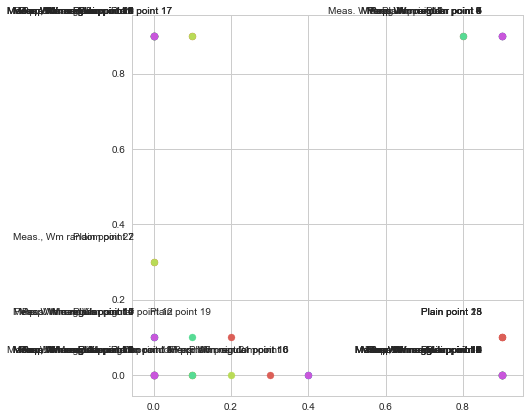

In [15]:
sns.set_palette('hls', len(greedys))
sns.set_style('whitegrid')

fig = plt.figure(figsize=(7,7))

for i, greedy in enumerate(greedys):
    labels = ['{0} point {1}'.format(g_labels[i], j) for j in range(greedy.n)] 
    
    ps = dict_ys[np.array(greedy.dict_sel, dtype=np.int32), :]
    
    plt.scatter(ps[:, 0], ps[:, 1], marker='o')

    for label, x, y in zip(labels, ps[:, 0], ps[:, 1]):
        plt.annotate(
            label, xy=(x, y), xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom')

plt.show()

### Can we find a closed form for the coefficients of this 4d solution? We look at the coefficients of the sub-domain solutions

In [10]:
np.random.seed(2)

y = np.random.random((1,4))
y = np.array([[0.1, 0.3, 0.6, 0.9]])

u, a = make_soln(y, fem_div, a_bar=a_bar, c=c)

u0, a0 = make_soln(y.mean()*np.ones((1,4)), fem_div, a_bar=a_bar, c=c)
u1, a1 = make_soln(np.array([[1,1,1e16,1e16]]), fem_div, a_bar=0, c=1)
u2, a2 = make_soln(np.array([[1e16,1,1e16,1]]), fem_div, a_bar=0, c=1)
u3, a3 = make_soln(np.array([[1e16,1e16,1,1]]), fem_div, a_bar=0, c=1)
u4, a4 = make_soln(np.array([[1,1e16,1,1e16]]), fem_div, a_bar=0, c=1)

u5, a5 = make_soln(np.array([[1,1e16,1e16,1e16]]), fem_div, a_bar=0, c=1)
u6, a6 = make_soln(np.array([[1e16,1,1e16,1e16]]), fem_div, a_bar=0, c=1)
u7, a7 = make_soln(np.array([[1e16,1e16,1,1e16]]), fem_div, a_bar=0, c=1)
u8, a8 = make_soln(np.array([[1e16,1e16,1e16,1]]), fem_div, a_bar=0, c=1)

# The forgotten corner solutions...?
u9, a9   = make_soln(np.array([[1,1,1,1e16]]), fem_div, a_bar=0, c=1)
u10, a10 = make_soln(np.array([[1e16,1,1,1]]), fem_div, a_bar=0, c=1)
u11, a11 = make_soln(np.array([[1,1e16,1,1]]), fem_div, a_bar=0, c=1)
u12, a12 = make_soln(np.array([[1,1,1e16,1]]), fem_div, a_bar=0, c=1)

u = u[0]
us=[]
us.append(u0[0])
us.append(u1[0])
us.append(u2[0])
us.append(u3[0])
us.append(u4[0])
us.append(u5[0])
us.append(u6[0])
us.append(u7[0])
us.append(u8[0])
us.append(u9[0])
us.append(u10[0])
us.append(u11[0])
us.append(u12[0])

[[ 0.1  0.3  0.6  0.9]]
[[ 0.3  0.7]
 [ 1.3  1.9]]


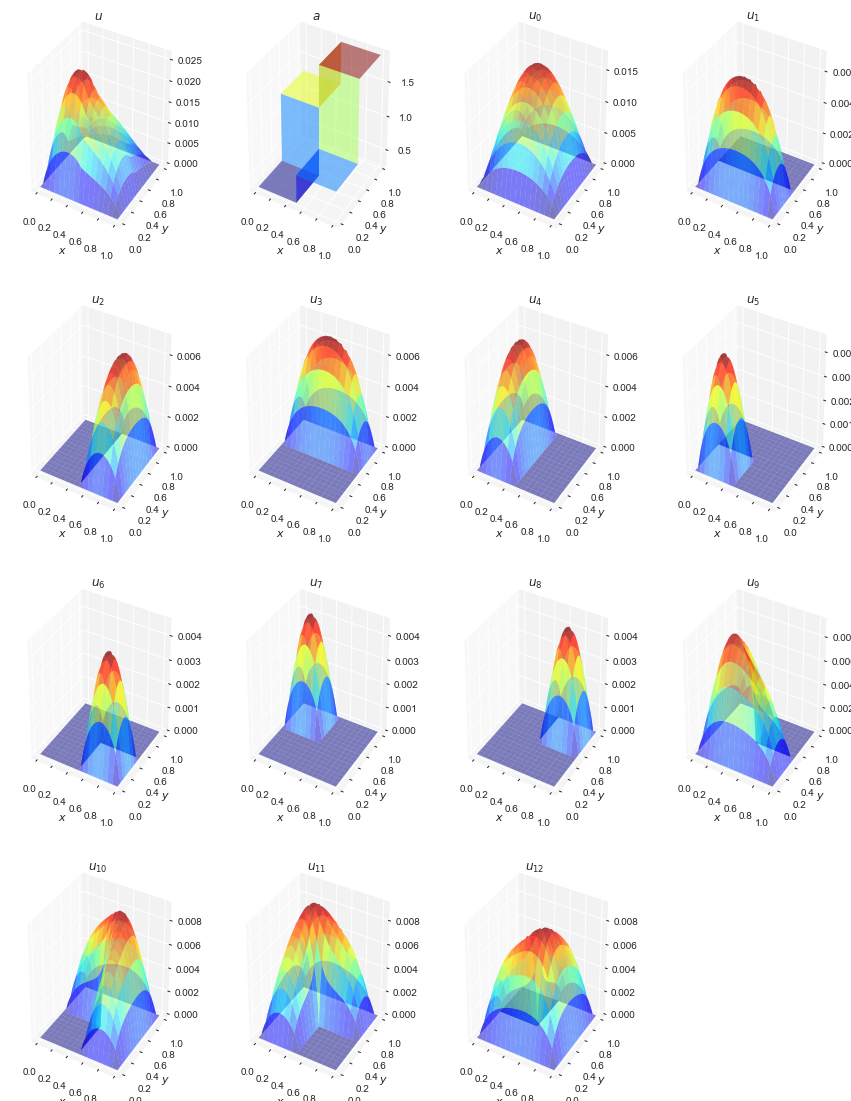

In [11]:
print(y)
print(a[0].values)

fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(4, 4, 1, projection='3d')
u.plot(ax, title='$u$')
ax = fig.add_subplot(4, 4, 2, projection='3d')
a[0].plot(ax, title='$a$')
for i,v in enumerate(us):
    ax = fig.add_subplot(4, 4, i+3, projection='3d')
    v.plot(ax, title=r'$u_{{{0}}}$'.format(i))

plt.show()

### Can we represent the solution $u$ in terms of the 9 components $u_0$ to $u_8$?
If so my theory is correct

Coefficients: [ 1.00050934  1.09395328 -0.23399475 -0.33498546  0.38640487 -2.06507751
  2.66867778  2.86159707 -2.92255491 -3.10478675 -3.0049918   3.01312789
  3.05684776]
eigenvalues:  [  2.70330900e+00   6.95655096e-02   3.52580459e-01   3.52580459e-01
   5.44582460e-02   1.49609425e-03   2.33571428e-02   1.01531786e-05
   9.64523626e-17   1.07151802e-02   1.07151802e-02   7.23369559e-05
   7.23369559e-05]
1.13609213381e-05
[[ 0.1  0.3  0.6  0.9]]


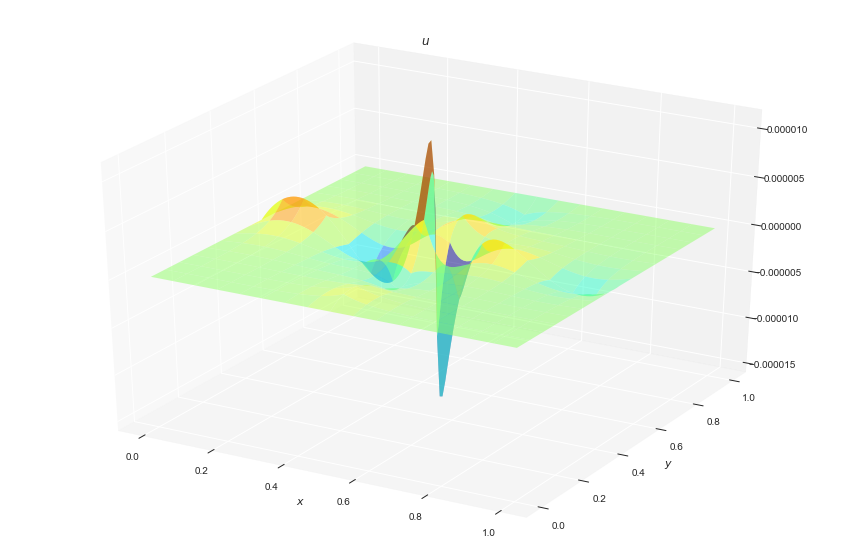

In [12]:
M = np.vstack([v.values.flatten() for v in us])
w = u.values.flatten()

C = M @ M.T
g = M @ w

#cf = np.linalg.lstsq(M.T, w)[0]
#print(cf)
cf = np.linalg.solve(C, g)
print("Coefficients:", cf)

#print(M @ M.T)
lambdas, V =  np.linalg.eig(M @ M.T)
print("eigenvalues: ", lambdas)

u_rec = pat.PWLinearSqDyadicH1(us[0].values * cf[0])
for i,v in enumerate(us[1:]):
    u_rec += v * cf[i+1]

print((u - u_rec).values.max())
print(y)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
(u-u_rec).plot(ax, title='$u$')
#ax = fig.add_subplot(2, 2, 2, projection='3d')
#corner.plot(ax, title='')
#ax = fig.add_subplot(2, 2, 3, projection='3d')
#u.plot(ax, title='')
#ax = fig.add_subplot(2, 2, 4, projection='3d')
#u5.plot(ax, title='')
plt.show()


eigenvalues:  [  2.70330900e+00   6.95655096e-02   3.52580459e-01   3.52580459e-01
   5.44582460e-02   1.49609425e-03   2.33571428e-02   1.01531786e-05
   9.64523626e-17   1.07151802e-02   1.07151802e-02   7.23369559e-05
   7.23369559e-05]


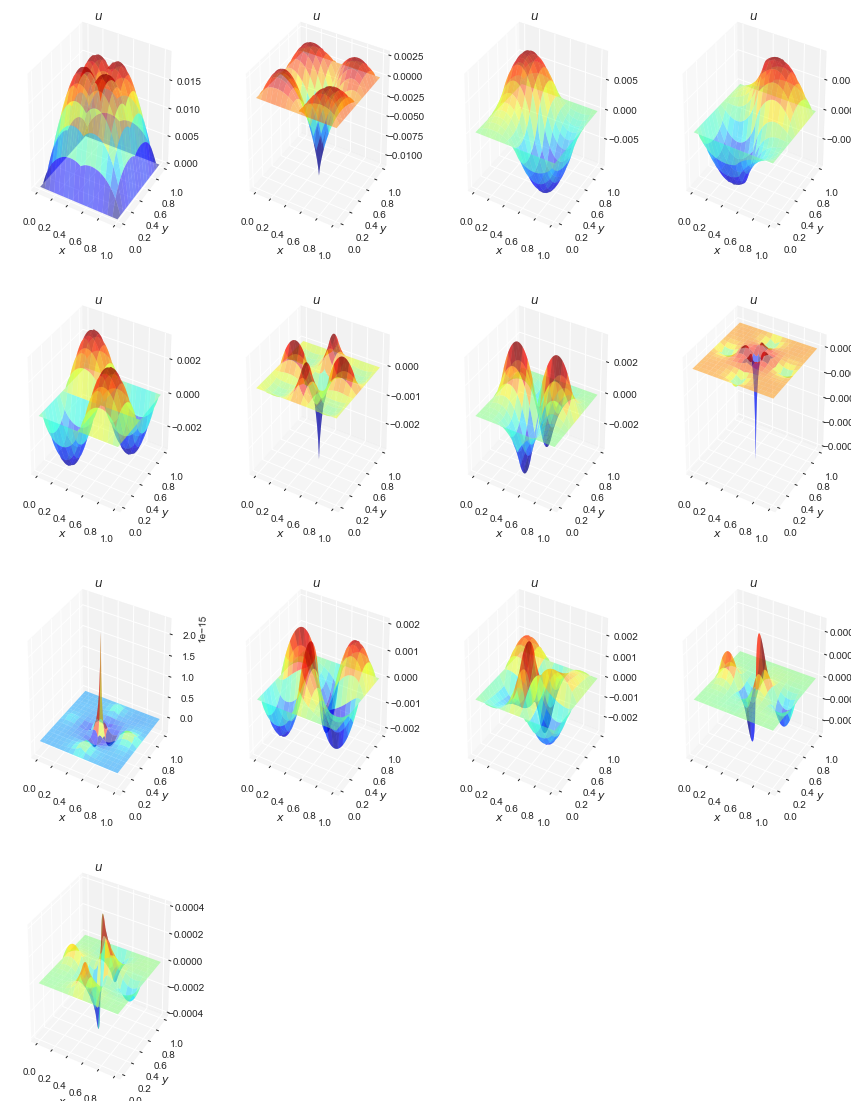

In [32]:
us_basis = pat.PWBasis(us)

lambdas, V =  np.linalg.eig(M @ M.T)
print("eigenvalues: ", lambdas)


fig = plt.figure(figsize=(15, 20))

for i, v in enumerate(V.T):
    ax = fig.add_subplot(4, 4, i+1, projection='3d')
    us_basis.reconstruct(v).plot(ax, title='$u$')
